In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_random_state
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.datasets import make_classification
import tensorflow.keras as keras
from sklearn.datasets import load_digits 
from sklearn.utils import shuffle

2022-12-23 01:00:49.027952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Hotpatch to return un-normalized class probabilities
# must be defined for score_samples_hotpatch to work
def _check_X(X, n_components=None, n_features=None, ensure_min_samples=1):
    X = check_array(X, dtype=[np.float64, np.float32],
                    ensure_min_samples=ensure_min_samples)
    if n_components is not None and X.shape[0] < n_components:
        raise ValueError('Expected n_samples >= n_components '
                         'but got n_components = %d, n_samples = %d'
                         % (n_components, X.shape[0]))
    if n_features is not None and X.shape[1] != n_features:
        raise ValueError("Expected the input data X have %d features, "
                         "but got %d features"
                         % (n_features, X.shape[1]))
    return X

# returning unweighted log probabilities:log(P(X|Z))
def score_samples_hotpatch(self, X):
        check_is_fitted(self)
        X = _check_X(X, None, self.means_.shape[1])
        return self._estimate_log_prob(X)

sklearn.mixture._base.BaseMixture.score_samples = score_samples_hotpatch
    
print("done")

done


In [4]:
# main agent class
# num_components: number of components in the initial model
# recluster_limit: number of novel observations required to trigger reclustering
# outlier_check: whether to check the CDF for the expected number of outliers at that distance


class Agent():
    def __init__(self, train_data, num_components=1, recluster_limit=5, outlier_check=False):
        self.num_components = num_components
        self.train_data = train_data
        self.model = GaussianMixture(n_components=num_components, 
                                     covariance_type='full', 
                                     n_init=10).fit(train_data)
        if self.num_components == 1:
            self.lp_threshold = min(self.model.score_samples(self.train_data))  # log probability threshold
        else:
            self.lp_threshold = min([max(i) for i in self.model.score_samples(self.train_data)])  # log probability threshold

        self.m_distances = np.array([self.m_dist(i) for i in self.train_data])
        self.m_threshold = max(np.array([self.m_dist(i) for i in self.train_data]))  # squared mahalanobis threshold
        self.classified_samples = []  # list of dicts with sample, prediction, m_dist, log_prob, metric, novel_flag
              
        self.novel_count = 0
        self.recluster_limit = recluster_limit
        self.outlier_check = outlier_check
        
    def novel_proportion(self):
        novel_prop = len([i for i in self.classified_samples if i["novel"] == 1]) / len(self.train_data)
        return novel_prop
    
    # return the log probability of the single sample for the most likely component
    # if return_all=True returns the log prob for all components
    def log_prob(self, sample, return_all=False):
        if len(sample.shape) == 1 or sample.shape[0] == 1:
            if return_all:
                return self.model.score_samples(sample.reshape(1,-1))[0]
#             print("score:")
#             print(self.model.score_samples(sample.reshape(1,-1))[0])
            return max(self.model.score_samples(sample.reshape(1,-1))[0])
        else:
            if return_all:
                return self.model.score_samples(sample)
            return max(self.model.score_samples(sample))

    # calculate minimum squared mahalanobis distance for a single sample
    # parameters: trained gmm model, data sample to classify, flag to return list of all distances
    def m_dist(self, sample, return_all=False):
        cluster_means = self.model.means_
        covariances = self.model.covariances_
        m_distances = []
        for i in range(len(cluster_means)):
            d = mahalanobis(cluster_means[i], sample, np.linalg.inv(covariances[i]))
            d2 = d**2
            m_distances.append(d2)
        if return_all:
            return m_distances
        else:
            return min(m_distances)
    
    # metric is either "log_prob" or "m_dist"
    def classify(self, sample, metric="m_dist"):
        sample = np.array(sample)
        pred = self.model.predict(sample.reshape(1,-1))[0]
        novel = 0
        md = self.m_dist(sample)
        lp = self.log_prob(sample)
        sample_dict = {"sample":sample, "pred":pred, "m_dist":md, "log_prob":lp}

        if metric == 'log_prob':
            if lp < self.lp_threshold:
                novel = 1
            sample_dict["metric"] = "log_prob"
            sample_dict["novel"] = novel
        elif metric == 'm_dist':

            if md > self.m_threshold:
                novel = 1
            sample_dict["metric"] = "m_dist"
            sample_dict["novel"] = novel
        else:
            print('***  ' + str(metric) + ' IS NOT A VALID METRIC  ***')
 
        self.novel_count += novel
        
        self.classified_samples.append(sample_dict)
        
        # reclustering
        if self.novel_count == self.recluster_limit:
#             print(str(self.novel_count) + " novel points detected. RECLUSTERING!")
            novel_proportion = len([i for i in self.classified_samples if i["novel"] == 1]) / len(self.train_data)
            min_candidate_m_dist = min([i["m_dist"] for i in self.classified_samples])
           
            # if TRUE, only check AIC if the candidates are determined to be novel
            if self.outlier_check == True:
#                 print("Checking CDF")
                if chi2.cdf(min_candidate_m_dist, self.train_data.shape[1]) > 1 - novel_proportion:
                    # candidate points are truly novel
                    new_data = np.array([np.array(i["sample"]) for i in self.classified_samples])
                    new_data = np.concatenate((self.train_data, new_data))  # add new samples to training data
                    new_model = GaussianMixture(n_components=self.num_components + 1, 
                                             covariance_type='full', 
                                             n_init=10).fit(new_data)
                    # compare AIC of new model with current model and choose the best
                    aic = self.model.aic(new_data)
                    new_aic = new_model.aic(new_data)
                    if new_aic < aic:
                        print("Using new model with " + str(new_model.n_components) + " components")
                        self.model = new_model
                        self.num_components += 1
                        self.novel_count = 0
                else:
                    print("Candidates are likely outliers and not truly novel")
            
            # if outlier_check=FALSE. Only check AIC
            else:
#                 print("checking AIC")
                new_data = np.array([np.array(i["sample"]) for i in self.classified_samples])
                new_data = np.concatenate((self.train_data, new_data))  # add new samples to training data
                new_model = GaussianMixture(n_components=self.num_components + 1, 
                                         covariance_type='full', 
                                         n_init=10).fit(new_data)
                # compare new model with current model and choose the best
                aic = self.model.aic(new_data)
                new_aic = new_model.aic(new_data)
                if new_aic < aic:
                    print("Using new model with " + str(new_model.n_components) + " components")
                    self.model = new_model
                    self.num_components += 1
                    self.novel_count = 0
#                 else:
#                     print("Keeping current model")
                
                
            
            self.novel_count = 0 # reset novel count after reclustering
                
        



## Below are some simple examples to demonstrate how the agent works

In [ ]:
np.random.seed(8)
data = np.random.multivariate_normal([0,0], [[0.3, 0], [0, 0.6]], size=(100))
# plt.plot(data[:,0], data[:,1], ls='none', marker='.')
# plt.axis([-10, 10, -10, 10])

a = Agent(data, num_components=1, recluster_limit=3)
points = np.random.normal(loc=[7, 7], scale=[1.0, 1.0], size=(200,2))
i = 0
while a.num_components == 1:
    a.classify(points[i])
    i += 1
print()
print("Classified samples: " + str(len(a.classified_samples)))
print("Model components: " + str(a.num_components))
print("m_dist threshold: " + str(a.m_threshold))
print("novel proportion: " + str(a.novel_proportion()))
plt.plot(data[:,0], data[:,1], ls='none', marker='.', color='blue')
plt.plot(points[:,0], points[:,1], ls='none', marker='.', color='green')
plt.axis([-10, 10, -10, 10])


In [ ]:
np.random.seed(8)
# same as above, but with outlier_check
a = Agent(data, num_components=1, recluster_limit=3, outlier_check=True)
data = np.random.multivariate_normal([0,0], [[0.3, 0], [0, 0.6]], size=(100))
points = np.random.normal(loc=[7, 7], scale=[1.0, 1.0], size=(200,2))

i = 0
while a.num_components == 1 and i < len(points):
    a.classify(points[i])
    i += 1
print()
print("Classified samples: " + str(len(a.classified_samples)))
print("Model components: " + str(a.num_components))
print("m_dist threshold: " + str(a.m_threshold))
print("novel proportion: " + str(a.novel_proportion()))
plt.plot(data[:,0], data[:,1], ls='none', marker='.', color='blue')
plt.plot(points[:,0], points[:,1], ls='none', marker='.', color='green')
plt.axis([-10, 10, -10, 10])

In [ ]:
np.random.seed(88)
# closer gaussians to trigger outlier detection
a = Agent(data, num_components=1, recluster_limit=3, outlier_check=True)
data = np.random.multivariate_normal([0,0], [[0.3, 0], [0, 0.6]], size=(200))
points = np.random.normal(loc=[2, 2], scale=[1.2, 1.2], size=(200,2))
i = 0
while a.num_components == 1 and i < len(points):
    a.classify(points[i])
    i += 1
print()
if i == len(points):
    print("** Failed to detect novel cluster **")
print("Classified samples: " + str(len(a.classified_samples)))
print("Model components: " + str(a.num_components))
print("m_dist threshold: " + str(a.m_threshold))
print("novel proportion: " + str(a.novel_proportion()))
plt.plot(data[:,0], data[:,1], ls='none', marker='.', color='blue')
plt.plot(points[:,0], points[:,1], ls='none', marker='.', color='green')
plt.axis([-10, 10, -10, 10])


In [6]:
# MNIST data
np.random.seed(88)
# load data
digit_data = load_digits()
n = digit_data['data'].shape[0]
x = digit_data['data']
y = digit_data['target']
required_samples = []
for class_num in range(10):
    x_main = x[y!=class_num]
    points = x[y==class_num]
    y_main = y[y!=class_num]
    y_novel = y[y==class_num]
    x_main, y_main = shuffle(x_main, y_main)
    
    a = Agent(x_main, num_components=9, recluster_limit=4, outlier_check=False)
    i = 0
    while a.num_components == 9 and i < len(points):
        a.classify(points[i])
        i += 1
    required_samples.append(len(a.classified_samples))
    print()
    print()
    print("For class: " + str(class_num))
    if i == len(points):
        print("** Failed to detect novel cluster **")
    print("Classified samples: " + str(len(a.classified_samples)))
    print("Model components: " + str(a.num_components))
    print("m_dist threshold: " + str(a.m_threshold))
    print("novel proportion: " + str(a.novel_proportion()))
    


Using new model with 10 components


For class: 0
Classified samples: 19
Model components: 10
m_dist threshold: 195.96130175325843
novel proportion: 0.0024706609017912293
Using new model with 10 components


For class: 1
Classified samples: 23
Model components: 10
m_dist threshold: 223.9733057230495
novel proportion: 0.002476780185758514
Using new model with 10 components


For class: 2
Classified samples: 92
Model components: 10
m_dist threshold: 362.97710108199254
novel proportion: 0.012345679012345678


For class: 3
** Failed to detect novel cluster **
Classified samples: 183
Model components: 9
m_dist threshold: 290.0196384878702
novel proportion: 0.009913258983890954
Using new model with 10 components


For class: 4
Classified samples: 4
Model components: 10
m_dist threshold: 180.9981597081179
novel proportion: 0.0024752475247524753
Using new model with 10 components


For class: 5
Classified samples: 46
Model components: 10
m_dist threshold: 445.0038416692484
novel proportion: 0.

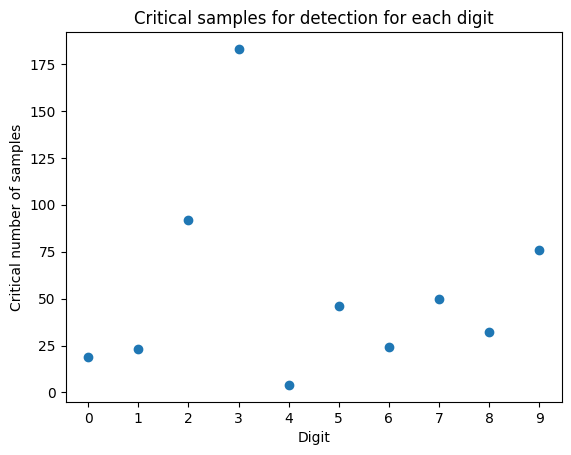

In [12]:

samples = [19, 23, 92, 183, 4, 46, 24, 50, 32, 76]
plt.title("Critical samples for detection for each digit")
plt.plot([i for i in range(10)], samples, ls='none', marker='o')
plt.xlabel("Digit")
plt.xticks([i for i in range(10)])
plt.ylabel("Critical number of samples")
plt.savefig("MNIST.pdf", format='pdf')